# 06 LightGBM: Optunaあり vs なし

`00_prepare_data.ipynb` で作成した Titanic の Train/Test を使い、
- PatternA: 固定ハイパーパラメータ（Optunaなし）
- PatternB: Optunaでハイパーパラメータ探索
を比較します。

In [24]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

try:
    import optuna
except ImportError as exc:
    raise ImportError('optuna が未インストールです。`uv pip install optuna` を実行してください。') from exc

warnings.filterwarnings('ignore')

SEED = 42
N_SPLITS = 5
N_TRIALS = 5
TIMEOUT_SEC = 300

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [25]:
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].astype(int)
X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].astype(int)

class_labels = np.sort(y_train_full.unique())
num_class = len(class_labels)
is_binary = num_class == 2

print(f'Train shape: {X_train_full.shape}')
print(f'Test shape : {X_test.shape}')
print(f'Classes    : {class_labels.tolist()}')

Train shape: (19536, 14)
Test shape : (29306, 14)
Classes    : [0, 1]


In [26]:
def make_lgbm_params(seed, custom_params=None):
    base_params = {
        'n_estimators': 300,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_child_samples': 20,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.0,
        'reg_lambda': 1.0,
        'random_state': seed,
        'bagging_seed': seed,
        'feature_fraction_seed': seed,
        'data_random_seed': seed,
        'deterministic': True,
        'force_col_wise': True
    }

    if is_binary:
        base_params.update({
            'objective': 'binary'
        })
    else:
        base_params.update({
            'objective': 'multiclass',
            'num_class': num_class
        })

    if custom_params is not None:
        base_params.update(custom_params)

    return base_params

def calc_auc(y_true, proba):
    if is_binary:
        return roc_auc_score(y_true, proba[:, 1])
    return roc_auc_score(y_true, proba, multi_class='ovr', average='macro')

def evaluate_pattern(method_name, custom_params=None):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_rows = []
    test_proba_folds = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_full, y_train_full), start=1):
        X_tr = X_train_full.iloc[tr_idx]
        y_tr = y_train_full.iloc[tr_idx]
        X_va = X_train_full.iloc[va_idx]
        y_va = y_train_full.iloc[va_idx]

        params = make_lgbm_params(SEED + fold, custom_params=custom_params)
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='binary_logloss' if is_binary else 'multi_logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        tr_proba = model.predict_proba(X_tr)
        tr_pred = model.predict(X_tr)
        va_proba = model.predict_proba(X_va)
        va_pred = model.predict(X_va)
        te_proba = model.predict_proba(X_test)
        te_pred = np.argmax(te_proba, axis=1)

        test_proba_folds.append(te_proba)

        for metrics in [
            {
                'Split': 'Train',
                'Accuracy': accuracy_score(y_tr, tr_pred),
                'F1_macro': f1_score(y_tr, tr_pred, average='macro'),
                'LogLoss': log_loss(y_tr, tr_proba, labels=class_labels),
                'AUC': calc_auc(y_tr, tr_proba)
            },
            {
                'Split': 'Valid',
                'Accuracy': accuracy_score(y_va, va_pred),
                'F1_macro': f1_score(y_va, va_pred, average='macro'),
                'LogLoss': log_loss(y_va, va_proba, labels=class_labels),
                'AUC': calc_auc(y_va, va_proba)
            },
            {
                'Split': 'Test',
                'Accuracy': accuracy_score(y_test, te_pred),
                'F1_macro': f1_score(y_test, te_pred, average='macro'),
                'LogLoss': log_loss(y_test, te_proba, labels=class_labels),
                'AUC': calc_auc(y_test, te_proba)
            }
        ]:
            fold_rows.append({
                'Method': method_name,
                'Fold': fold,
                'Split': metrics['Split'],
                'Accuracy': metrics['Accuracy'],
                'F1_macro': metrics['F1_macro'],
                'LogLoss': metrics['LogLoss'],
                'AUC': metrics['AUC']
            })

    fold_df = pd.DataFrame(fold_rows)
    mean_df = fold_df.groupby(['Method', 'Split'], as_index=False)[['Accuracy', 'F1_macro', 'LogLoss', 'AUC']].mean()

    test_proba_mean = np.mean(np.stack(test_proba_folds, axis=0), axis=0)
    test_pred_mean = np.argmax(test_proba_mean, axis=1)

    return fold_df, mean_df, test_pred_mean, test_proba_mean

In [27]:
def optuna_objective(trial):
    trial_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 80),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_losses = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_full, y_train_full), start=1):
        X_tr = X_train_full.iloc[tr_idx]
        y_tr = y_train_full.iloc[tr_idx]
        X_va = X_train_full.iloc[va_idx]
        y_va = y_train_full.iloc[va_idx]

        params = make_lgbm_params(SEED + fold, custom_params=trial_params)
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='binary_logloss' if is_binary else 'multi_logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
        )

        va_proba = model.predict_proba(X_va)
        fold_loss = log_loss(y_va, va_proba, labels=class_labels)
        fold_losses.append(fold_loss)

    return float(np.mean(fold_losses))

In [28]:
baseline_fold_df, baseline_summary_df, baseline_test_pred, baseline_test_proba = evaluate_pattern(
    method_name='NoOptuna(FixedParams)',
    custom_params=None
)

study = optuna.create_study(direction='minimize', study_name='lgbm_optuna_vs_no_optuna')
study.optimize(optuna_objective, n_trials=N_TRIALS, timeout=TIMEOUT_SEC, show_progress_bar=False)

best_params = study.best_trial.params
print('Best trial:', study.best_trial.number)
print('Best valid logloss:', study.best_value)
print('Best params:')
print(best_params)

[LightGBM] [Info] Number of positive: 4116, number of negative: 11512
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263373 -> initscore=-1.028508
[LightGBM] [Info] Start training from score -1.028508
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM]

[I 2026-02-20 08:51:33,941] A new study created in memory with name: lgbm_optuna_vs_no_optuna


[LightGBM] [Info] Number of positive: 4116, number of negative: 11512
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263373 -> initscore=-1.028508
[LightGBM] [Info] Start training from score -1.028508
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM]

[I 2026-02-20 08:51:35,281] Trial 0 finished with value: 0.3631520281754598 and parameters: {'n_estimators': 357, 'learning_rate': 0.19757919264880877, 'num_leaves': 51, 'min_child_samples': 63, 'subsample': 0.9857908030583076, 'colsample_bytree': 0.9196727371816698, 'reg_alpha': 0.004673272003367324, 'reg_lambda': 7.415435679931887}. Best is trial 0 with value: 0.3631520281754598.


[LightGBM] [Info] Number of positive: 4116, number of negative: 11512
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263373 -> initscore=-1.028508
[LightGBM] [Info] Start training from score -1.028508
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM]

[I 2026-02-20 08:51:41,366] Trial 1 finished with value: 0.36131901070524464 and parameters: {'n_estimators': 322, 'learning_rate': 0.018989487966050347, 'num_leaves': 62, 'min_child_samples': 13, 'subsample': 0.7581304175221473, 'colsample_bytree': 0.9688001654809398, 'reg_alpha': 3.0461660297225555, 'reg_lambda': 1.8623442747210914e-08}. Best is trial 1 with value: 0.36131901070524464.


[LightGBM] [Info] Number of positive: 4116, number of negative: 11512
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263373 -> initscore=-1.028508
[LightGBM] [Info] Start training from score -1.028508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2026-02-20 08:51:51,782] Trial 2 finished with value: 0.36488335467580757 and parameters: {'n_estimators': 487, 'learning_rate': 0.018681400053005063, 'num_leaves': 100, 'min_child_samples': 11, 'subsample': 0.8093503553305713, 'colsample_bytree': 0.725536677613398, 'reg_alpha': 8.032622149836147, 'reg_lambda': 0.012609442104954663}. Best is trial 1 with value: 0.36131901070524464.


[LightGBM] [Info] Number of positive: 4116, number of negative: 11512
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263373 -> initscore=-1.028508
[LightGBM] [Info] Start training from score -1.028508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2026-02-20 08:51:59,779] Trial 3 finished with value: 0.36695698092185086 and parameters: {'n_estimators': 345, 'learning_rate': 0.014882858945109557, 'num_leaves': 113, 'min_child_samples': 54, 'subsample': 0.680658626492095, 'colsample_bytree': 0.6597529068313701, 'reg_alpha': 0.1024868181556505, 'reg_lambda': 8.087019059267371}. Best is trial 1 with value: 0.36131901070524464.


[LightGBM] [Info] Number of positive: 4116, number of negative: 11512
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263373 -> initscore=-1.028508
[LightGBM] [Info] Start training from score -1.028508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 846
[LightGBM] [

[I 2026-02-20 08:52:07,684] Trial 4 finished with value: 0.36267210804615924 and parameters: {'n_estimators': 398, 'learning_rate': 0.015162526017746909, 'num_leaves': 75, 'min_child_samples': 68, 'subsample': 0.9923683239481799, 'colsample_bytree': 0.7675368569289494, 'reg_alpha': 0.7668696170741225, 'reg_lambda': 4.744236418100622e-05}. Best is trial 1 with value: 0.36131901070524464.


Best trial: 1
Best valid logloss: 0.36131901070524464
Best params:
{'n_estimators': 322, 'learning_rate': 0.018989487966050347, 'num_leaves': 62, 'min_child_samples': 13, 'subsample': 0.7581304175221473, 'colsample_bytree': 0.9688001654809398, 'reg_alpha': 3.0461660297225555, 'reg_lambda': 1.8623442747210914e-08}


In [29]:
optuna_fold_df, optuna_summary_df, optuna_test_pred, optuna_test_proba = evaluate_pattern(
    method_name='Optuna(TunedParams)',
    custom_params=best_params
)

comparison_df = pd.concat([baseline_summary_df, optuna_summary_df], ignore_index=True)
comparison_df['Split'] = pd.Categorical(comparison_df['Split'], categories=['Train', 'Valid', 'Test'], ordered=True)
comparison_df = comparison_df.sort_values(['Split', 'Method']).reset_index(drop=True)
display(comparison_df)

pivot_acc = comparison_df.pivot(index='Split', columns='Method', values='Accuracy')

diff = pd.DataFrame({
    'Accuracy diff (Optuna - NoOptuna)': pivot_acc['Optuna(TunedParams)'] - pivot_acc['NoOptuna(FixedParams)']
}).reset_index()

print('Difference by split (Optuna - NoOptuna)')
display(diff)

[LightGBM] [Info] Number of positive: 4116, number of negative: 11512
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263373 -> initscore=-1.028508
[LightGBM] [Info] Start training from score -1.028508
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM] [Info] Number of positive: 4116, number of negative: 11513
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263357 -> initscore=-1.028595
[LightGBM] [Info] Start training from score -1.028595
[LightGBM]

,Method,Split,Accuracy,F1_macro,LogLoss,AUC
0,NoOptuna(FixedParams),Train,0.857532,0.801544,0.311175,0.921158
1,Optuna(TunedParams),Train,0.862331,0.808655,0.305678,0.925556
2,NoOptuna(FixedParams),Valid,0.833385,0.767095,0.358637,0.884922
3,Optuna(TunedParams),Valid,0.831235,0.764549,0.361247,0.883362
4,NoOptuna(FixedParams),Test,0.833693,0.766399,0.361984,0.881976
5,Optuna(TunedParams),Test,0.832533,0.765834,0.364146,0.880333


Difference by split (Optuna - NoOptuna)


,Split,Accuracy diff (Optuna - NoOptuna)
0,Train,0.004799
1,Valid,-0.002150
2,Test,-0.001160


Test prediction agreement (NoOptuna vs Optuna): 0.9808


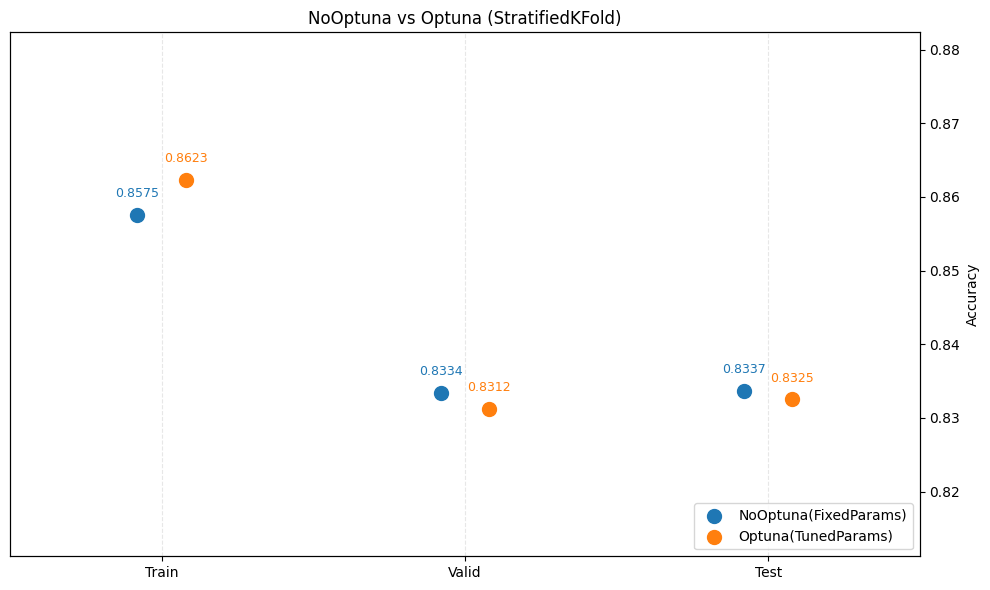

In [30]:
agreement = (baseline_test_pred == optuna_test_pred).mean()
print(f'Test prediction agreement (NoOptuna vs Optuna): {agreement:.4f}')

split_order = ['Train', 'Valid', 'Test']
x = np.arange(len(split_order))
offset = 0.08

acc_no = [pivot_acc.loc[s, 'NoOptuna(FixedParams)'] for s in split_order]
acc_opt = [pivot_acc.loc[s, 'Optuna(TunedParams)'] for s in split_order]

fig, ax = plt.subplots(figsize=(10, 6))
ax_right = ax.twinx()

ax.set_xlim(-0.5, len(split_order) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(split_order)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

ax_right.scatter(x - offset, acc_no, s=100, label='NoOptuna(FixedParams)', color='tab:blue')
ax_right.scatter(x + offset, acc_opt, s=100, label='Optuna(TunedParams)', color='tab:orange')

for i, score in enumerate(acc_no):
    ax_right.text(x[i] - offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:blue')
for i, score in enumerate(acc_opt):
    ax_right.text(x[i] + offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:orange')

all_acc = np.array(acc_no + acc_opt)
ax_right.set_ylabel('Accuracy')
ax_right.set_ylim(max(0.0, all_acc.min() - 0.02), min(1.0, all_acc.max() + 0.02))
ax_right.legend(loc='lower right')

plt.title('NoOptuna vs Optuna (StratifiedKFold)')
plt.tight_layout()
plt.show()